# Workspace Codebook中用LSTM预测价格走势
* Zansong Zhu

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras.layers import RepeatVector
import numpy as np
import pandas as pd

In [2]:
import refinitiv.dataplatform.eikon as ek

ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

In [3]:
my_eur = ek.get_timeseries('EUR=', interval='minute')

In [4]:
n = len(my_eur)
window_size = 3
feature_no = 3
flat = []
for i in range(0,n-window_size+1):
    cur  = my_eur.iloc[i:i+window_size,[0,1,2]]
    for j in cur.values:
        flat+=list(j)

In [5]:
vmax = max(flat); vmin = min(flat)

In [6]:
flat = list((np.array(flat) - min(flat))/(max(flat) - min(flat)))

In [7]:
myds = np.array(flat)[np.newaxis,:]

In [8]:
myds = myds.reshape((round(myds.shape[1]/(window_size*feature_no)),window_size,feature_no))

In [9]:
x_train = myds[:-1];x_test = myds[-1:]

In [10]:
y_train = []
for i in range(0,len(x_train)-1):
    y_train.append(x_train[i+1][2][2])

In [11]:
x_train = x_train[:len(x_train)-1]

In [12]:
model = Sequential()

model.add(LSTM(6, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
       
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

adam = keras.optimizers.Adam(learning_rate=0.07,decay=0.1)
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 247
Trainable params: 247
Non-trainable params: 0
_________________________________________________________________


2025-04-12 07:07:07.844897: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-04-12 07:07:07.849614: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2499995000 Hz
2025-04-12 07:07:07.849906: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561d039b3720 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-12 07:07:07.849948: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [13]:
history = model.fit(x_train, y_train, epochs=100, verbose=0, shuffle=False)

<function matplotlib.pyplot.show(close=None, block=None)>

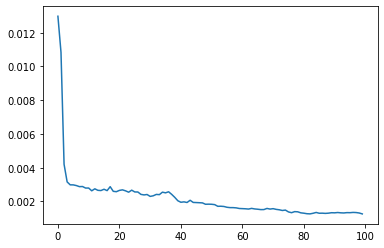

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show

In [15]:
pred = model.predict(x_train)
result = pd.DataFrame(x_train[0:,-1,-1]<y_train,columns=['tlabel'])
result['plabel'] = list(x_train[0:,-1,-1]<pred[:,-1])
print('train acc:',result[result.tlabel==result.plabel].shape[0]/result.shape[0])

train acc: 0.3648291863349068


<function matplotlib.pyplot.show(close=None, block=None)>

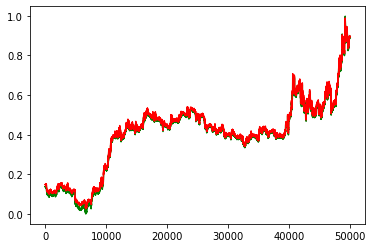

In [16]:
plt.plot(y_train, color='green', label = "Data")
plt.plot(pred, color='red', label = "predict")
plt.show

In [17]:
pred_test = model.predict(x_test)

In [18]:
pred_test

array([[0.9031217]], dtype=float32)

In [19]:
price = vmin + pred_test*(vmax-vmin)

In [20]:
price[0]

array([1.1365077], dtype=float32)